In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.optimize import Bounds
from scipy.optimize import fsolve


In [51]:
data = pd.read_excel('SP500 for Code.xlsx', sheet_name='SP50 2015')


In [52]:
data

,Date,APPLE,NVIDIA,MICROSOFT,AMAZON.COM,META PLATFORMS A,ALPHABET 'A',ELI LILLY,BROADCOM,TESLA,...,CATERPILLAR,DANAHER,S&P GLOBAL,SERVICENOW,TEXAS INSTRUMENTS,PHILIP MORRIS INTL.,WALT DISNEY,QUALCOMM,MORGAN STANLEY,PFIZER
0,2014-01-01,20.0364,0.4005,37.4100,19.9395,54.6490,28.0449,51.0000,5.2879,10.0286,...,90.8100,51.8637,78.2000,56.0100,43.910,87.13,76.40,74.25,31.36,29.0357
1,2014-01-02,19.7546,0.3965,37.1600,19.8985,54.7100,27.8550,50.7300,5.2650,10.0067,...,89.8700,51.3598,77.7500,55.6900,43.100,86.02,76.27,73.32,31.03,28.8745
2,2014-01-03,19.3207,0.3917,36.9100,19.8220,54.5570,27.6518,51.1000,5.2850,9.9707,...,89.8200,51.4337,77.5400,55.1800,43.290,85.53,76.11,72.89,31.51,28.9314
3,2014-01-06,19.4261,0.3970,36.1300,19.6815,57.2000,27.9601,51.5300,5.2490,9.8000,...,88.6400,50.9836,77.3800,55.7300,42.930,84.93,75.82,72.70,31.62,28.9598
4,2014-01-07,19.2870,0.4035,36.4100,19.9015,57.9200,28.4991,51.1900,5.2994,9.9573,...,88.9300,51.4068,78.0600,57.7800,42.700,84.68,76.34,73.24,31.52,29.1399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,2024-10-09,229.5400,132.6500,417.4600,185.1700,590.5100,161.8600,919.7400,185.9500,241.0500,...,396.1899,269.2300,521.4700,938.6499,204.970,120.18,93.60,170.22,109.04,30.1900
2811,2024-10-10,229.0400,134.8100,415.8401,186.6500,583.8301,162.0800,910.6899,185.6900,238.7700,...,396.6399,266.4500,515.1201,944.6299,202.470,119.39,92.99,168.52,108.08,29.3400
2812,2024-10-11,227.5500,134.8000,416.3201,188.8200,589.9500,163.2400,932.0601,181.4800,217.8000,...,402.0200,270.3301,522.0100,938.5901,205.110,120.10,94.13,169.98,110.46,29.1600
2813,2024-10-14,231.3000,138.0700,419.1399,187.5400,590.4199,164.9600,929.5100,182.3100,219.1600,...,393.9500,271.5601,527.5200,944.6899,208.655,120.08,94.97,178.04,112.28,29.0800


In [53]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
#take data frpm 2020
data = data.loc['2019-12-31':'2024-10-15']
data

,APPLE,NVIDIA,MICROSOFT,AMAZON.COM,META PLATFORMS A,ALPHABET 'A',ELI LILLY,BROADCOM,TESLA,WALMART,...,CATERPILLAR,DANAHER,S&P GLOBAL,SERVICENOW,TEXAS INSTRUMENTS,PHILIP MORRIS INTL.,WALT DISNEY,QUALCOMM,MORGAN STANLEY,PFIZER
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,73.4125,5.8825,157.7000,92.3920,205.2500,66.9695,131.4300,31.602,27.8887,39.6133,...,147.6800,136.0431,273.0500,282.3201,128.290,85.09,144.63,88.23,51.12,37.1406
2020-01-01,73.4125,5.8825,157.7000,92.3920,205.2500,66.9695,131.4300,31.602,27.8887,39.6133,...,147.6800,136.0431,273.0500,282.3201,128.290,85.09,144.63,88.23,51.12,37.1406
2020-01-02,75.0875,5.9977,160.6200,94.9005,209.7800,68.4340,132.2100,32.239,28.6840,39.6467,...,150.5300,137.4879,277.8401,291.2400,129.570,85.19,148.20,88.69,52.04,37.1027
2020-01-03,74.3575,5.9017,158.6200,93.7485,208.6700,68.0760,131.7700,31.419,29.5340,39.2967,...,148.4400,136.6369,276.9099,291.1001,127.850,85.03,146.50,87.02,51.20,36.9037
2020-01-06,74.9500,5.9265,159.0300,95.1440,212.6000,69.8905,132.2600,31.372,30.1027,39.2167,...,148.3400,137.0447,279.0400,292.8701,126.960,86.02,145.65,86.51,51.02,36.8563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-09,229.5400,132.6500,417.4600,185.1700,590.5100,161.8600,919.7400,185.950,241.0500,80.4000,...,396.1899,269.2300,521.4700,938.6499,204.970,120.18,93.60,170.22,109.04,30.1900
2024-10-10,229.0400,134.8100,415.8401,186.6500,583.8301,162.0800,910.6899,185.690,238.7700,79.6100,...,396.6399,266.4500,515.1201,944.6299,202.470,119.39,92.99,168.52,108.08,29.3400
2024-10-11,227.5500,134.8000,416.3201,188.8200,589.9500,163.2400,932.0601,181.480,217.8000,80.1000,...,402.0200,270.3301,522.0100,938.5901,205.110,120.10,94.13,169.98,110.46,29.1600


In [54]:
data.info()
#print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1251 entries, 2019-12-31 to 2024-10-15
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   APPLE                     1251 non-null   float64
 1   NVIDIA                    1251 non-null   float64
 2   MICROSOFT                 1251 non-null   float64
 3   AMAZON.COM                1251 non-null   float64
 4   META PLATFORMS A          1251 non-null   float64
 5   ALPHABET 'A'              1251 non-null   float64
 6   ELI LILLY                 1251 non-null   float64
 7   BROADCOM                  1251 non-null   float64
 8   TESLA                     1251 non-null   float64
 9   WALMART                   1251 non-null   float64
 10  JP MORGAN CHASE & CO.     1251 non-null   float64
 11  EXXON MOBIL               1251 non-null   float64
 12  UNITEDHEALTH GROUP        1251 non-null   float64
 13  ORACLE                    1251 non-null   flo

In [55]:
returns = data.pct_change().dropna()

returns = returns[returns.sum(axis=1) != 0]

returns.head()

,APPLE,NVIDIA,MICROSOFT,AMAZON.COM,META PLATFORMS A,ALPHABET 'A',ELI LILLY,BROADCOM,TESLA,WALMART,...,CATERPILLAR,DANAHER,S&P GLOBAL,SERVICENOW,TEXAS INSTRUMENTS,PHILIP MORRIS INTL.,WALT DISNEY,QUALCOMM,MORGAN STANLEY,PFIZER
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.022816,0.019584,0.018516,0.027151,0.022071,0.021868,0.005935,0.020157,0.028517,0.000843,...,0.019298,0.010620,0.017543,0.031595,0.009977,0.001175,0.024684,0.005214,0.017997,-0.001020
2020-01-03,-0.009722,-0.016006,-0.012452,-0.012139,-0.005291,-0.005231,-0.003328,-0.025435,0.029633,-0.008828,...,-0.013884,-0.006190,-0.003348,-0.000480,-0.013275,-0.001878,-0.011471,-0.018830,-0.016141,-0.005363
2020-01-06,0.007968,0.004202,0.002585,0.014886,0.018834,0.026654,0.003719,-0.001496,0.019256,-0.002036,...,-0.000674,0.002985,0.007692,0.006080,-0.006961,0.011643,-0.005802,-0.005861,-0.003516,-0.001284
2020-01-07,-0.004703,0.012098,-0.009118,0.002092,0.002164,-0.001932,0.001890,-0.003443,0.038797,-0.009266,...,-0.013213,0.009831,0.006952,0.000136,0.019297,0.004418,0.000343,0.028436,-0.001960,-0.003345
2020-01-08,0.016086,0.001884,0.015928,-0.007809,0.010138,0.007118,0.009056,-0.012474,0.049206,-0.003431,...,0.008881,0.001025,0.014343,0.009354,0.002705,0.018981,-0.002059,-0.002922,0.012765,0.008001


In [56]:
#monthly_returns = returns.resample('M').agg(lambda x: (x+1).prod() - 1)
monthly_returns = data.resample('M').last().pct_change().dropna()

/var/folders/cv/6mdsb4ks2nq321vt7d4wvhdr0000gn/T/ipykernel_88365/683482215.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = data.resample('M').last().pct_change().dropna()


In [57]:
cov_matrix = monthly_returns.cov() * 12 # do it with corr matrix later
mu = np.array(monthly_returns.mean()) * 12
vol = np.array(monthly_returns.std()) * np.sqrt(12)

In [58]:
mu, vol

(array([ 0.2832282 ,  0.78310647,  0.22820092,  0.19985083,  0.30846131,
         0.22476748,  0.45327838,  0.40514378,  0.69284703,  0.16833006,
         0.13447073,  0.17047619,  0.15269177,  0.28959956,  0.10972232,
         0.1472115 ,  0.03917341,  0.16588407,  0.08305466,  0.25755711,
         0.18979786,  0.08812874,  0.06732744,  0.26004087,  0.09566576,
         0.07481434,  0.38816996,  0.18859615,  0.15293446,  0.06495943,
         0.23479298,  0.15186303,  0.05607185,  0.19472832,  0.11471597,
         0.15417832,  0.09377447,  0.08173102,  0.15358304,  0.33052029,
        -0.0528857 ,  0.21359   ,  0.25029021,  0.17514003,  0.17099416,
         0.29104243,  0.12054779,  0.0933415 , -0.02936108,  0.20309182,
         0.2157618 , -0.01129653]),
 array([0.2928597 , 0.50535358, 0.22554326, 0.33081351, 0.41793007,
        0.2707508 , 0.30886991, 0.30663431, 0.77064807, 0.1897887 ,
        0.27491192, 0.34299675, 0.20631042, 0.2939959 , 0.23802081,
        0.27474211, 0.17412087

In [59]:
def QP(x, cov_matrix, mu, gamma):
    
    return 0.5 * x.T @ cov_matrix @ x - gamma * x.T @ mu

In [60]:
vecteur_unitaire = np.ones(len(returns.columns))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

initial_weights = np.ones(len(returns.columns)) / len(returns.columns)

vecteur_unitaire.shape , initial_weights.shape , cov_matrix.shape, mu.shape, vol.shape

((52,), (52,), (52, 52), (52,), (52,))

In [61]:
def efficient_frontier(gamma, constraints):

    res = minimize(QP, initial_weights, args=(cov_matrix, mu, gamma), constraints=constraints)
    optimized_weights = res.x
    mu_optimized = mu @ optimized_weights
    vol_optimized = np.sqrt(optimized_weights.T @ cov_matrix @ optimized_weights)
    
    return mu_optimized, vol_optimized, optimized_weights

In [62]:
mu_efficient_frontier = []
vol_efficient_frontier = []
weights_efficient_frontier = []

for gamma in np.linspace(-0.5,2,100):
    mu_optimized, vol_optimized, optimized_weights = efficient_frontier(gamma, constraints)
    mu_efficient_frontier.append(mu_optimized)
    vol_efficient_frontier.append(vol_optimized)
    weights_efficient_frontier.append(optimized_weights)

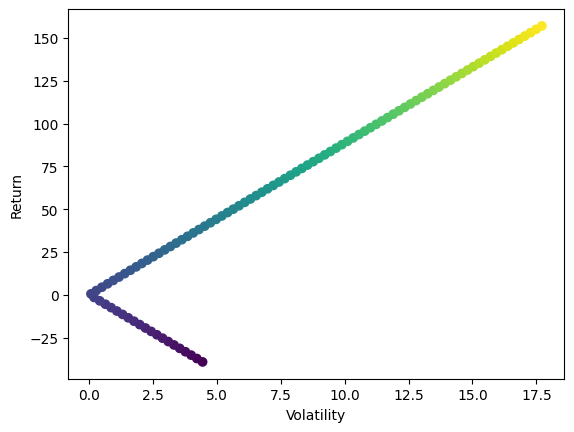

In [63]:
plt.scatter(vol_efficient_frontier ,mu_efficient_frontier , c = np.linspace(-0.5,2,100))
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [64]:
vol_efficient_frontier

[4.434686512611259,
 4.2109947242199866,
 3.987294990657744,
 3.7636482790456345,
 3.5399097634338292,
 3.316217366474144,
 3.0924753720061293,
 2.868798232037822,
 2.645071022620946,
 2.4213826362602098,
 2.197709368346618,
 1.9740704554046162,
 1.7504491193190694,
 1.5268877422081635,
 1.303412420767586,
 1.0800291017930148,
 0.8556883215006713,
 0.6323970231265519,
 0.40933964423489166,
 0.1885038746580175,
 0.0651620192602783,
 0.27111703809721804,
 0.49256581190805027,
 0.7156933703836406,
 0.939342120470524,
 1.1633413740676568,
 1.3867585873969817,
 1.6101244973378985,
 1.833559888800426,
 2.057080332640091,
 2.2807058626992127,
 2.5043092399645266,
 2.7279789524393743,
 2.9516585623756253,
 3.1753205218973037,
 3.3989599570064475,
 3.6226878840997783,
 3.84644008265264,
 4.070095096568674,
 4.293763095414247,
 4.517482249283493,
 4.741252951238187,
 4.964805683908481,
 5.188601044168974,
 5.412126118753745,
 5.6359592789250765,
 5.859622480687139,
 6.08347004075511,
 6.30716562